# Project 2: Radio Data Aanalysis (Part 1 - Calibration)

By: Michael Jafs



Module imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from rich.pretty import Pretty
from sigpyproc.readers import FilReader

### Project Goal:

For this first part of the analysis, we have raw radio data and we would like to calibrate to a known source. We also have data from observing a calibrator source that we would like to use for calibration.

Beginning with loading in the data...

In [2]:
bs = FilReader('../data/blank_sky.fil')


In [3]:
blank_sky_Fil = FilReader('../data/blank_sky.fil')
calibrator_source_Fil = FilReader('../data/calibrator_source.fil')
# myFil_blank_sky
calibrator_source_Fil

We can inspect the header of the raw radio data (this is our blank_sky file):

In [4]:
Pretty(blank_sky_Fil.header)

Header(
    filename='../data/blank_sky.fil',
    data_type='filterbank',
    nchans=1024,
    foff=-0.390625,
    fch1=800.0,
    nbits=32,
    tsamp=0.00032768,
    tstart=60638.34381999473,
    nsamples=30518,
    nifs=1,
    coord=<SkyCoord (ICRS): (ra, dec) in deg
    (68.75000238, 45.02999878)>,
    azimuth=<Angle 0. deg>,
    zenith=<Angle 0. deg>,
    telescope='CHIME',
    backend='CHIME',
    source='Fake',
    frame='topocentric',
    ibeam=1,
    nbeams=1,
    dm=0.0,
    period=0,
    accel=0,
    signed=0,
    rawdatafile='test.dat',
    stream_info=StreamInfo(
        entries=[
            FileInfo(
                filename='../data/blank_sky.fil',
                hdrlen=414,
                datalen=125001728,
                nsamples=30518,
                tstart=60638.34381999473,
                tsamp=0.00032768
            )
        ]
    )
)

## Part 1: Theoretical Spectrum

The calibrator source observed is 3C 129, a point source at 400 MHz with $S_{400} = 8.684$ Jy and a spectral index of $\alpha = -0.6$. We can begin by plotting the theoretical spectrum to get a sense for what things in general should look like. Our model is a power law that's been scaled to the reference flux density with a spectral index given by $alpha$:


In [5]:
#Define the function to plot the theoretical spectrum
#TODO: fill out the doc string
def theoretical_spectrum(freq, alpha, S):
    """
    Return the flux density in Jy for a given frequency in MHz

    Params
    ------
    freq
        The frequencies over which the spectrum is to be plotted
    alpha
        The Spectral Index
    S
        The reference flux density used to scale the spectrum to some established value at a given frequency

    Returns
    -------
    S_nu
        The flux density at a given frequency
    """
    return S*(freq/400.0)**alpha

We can now use the function to plot the theoretical spectrum across the CHIME frequency band.

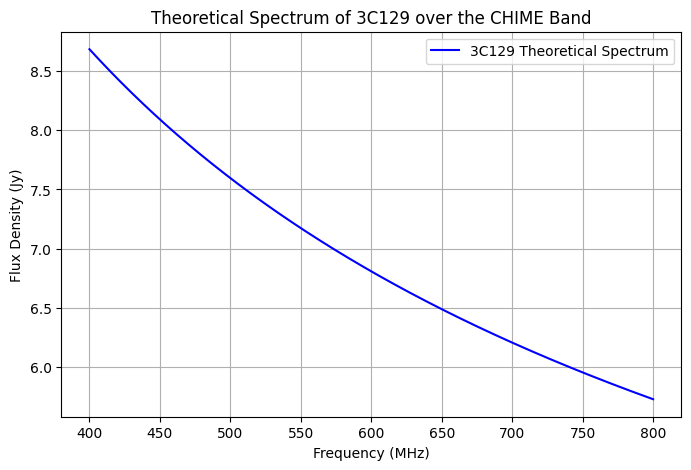

In [6]:
#Flux params of our calibrator source
alpha = -0.6
S400 = 8.684

#array of CHIME frequencies
#We go from 800 -> 400 to construct a theoretical flux array that is indexed
# in the same way. This way our theoretical flux array matches the indexing
# of the measured data set that has the frequencies in a decending order.
chime_freqs = np.linspace(400, 800, 1024)

#Calculate the theoretical flux at ehach frequency
flux_theory = theoretical_spectrum(chime_freqs, alpha, S400)

#Plot the theoretical spectrum
plt.figure(figsize=(8, 5))
plt.plot(chime_freqs, flux_theory, label='3C129 Theoretical Spectrum', color='blue')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Flux Density (Jy)')
plt.title('Theoretical Spectrum of 3C129 over the CHIME Band')
plt.legend()
plt.grid(True)
plt.show()

## Part 2: Calibrator Source Average Spectrum

Now let's plot the average spectrum of the calibrator source and compare to the theoretical spectrum. We first need to compute the average spectrum given the files read in initially using sigpyproc. After that, we can make a simple plot with the same axes as the theoretical spectrum above.

/home/mike/anaconda3/envs/641_projects_py12/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

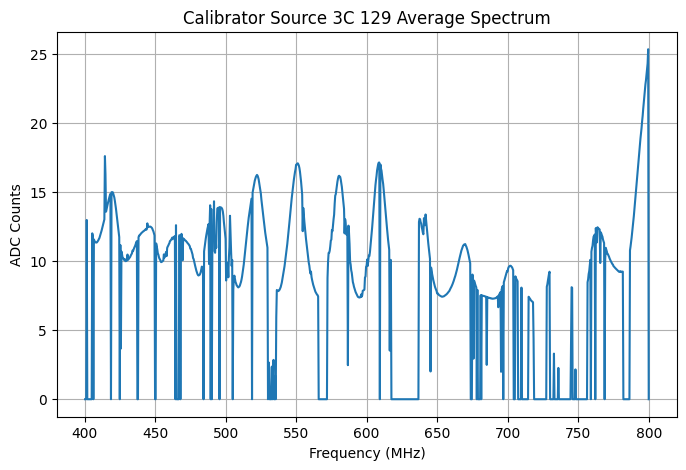

In [7]:
#compute the filterbank object statistics
calibrator_source_Fil.compute_stats()

#use the results above to plot the average spectrum
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_title("Calibrator Source 3C 129 Average Spectrum")
ax.plot(calibrator_source_Fil.header.chan_freqs, calibrator_source_Fil.chan_stats.mean)
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("ADC Counts")
ax.grid(True)

#### Comparing to the theoretical spectrum of the source:

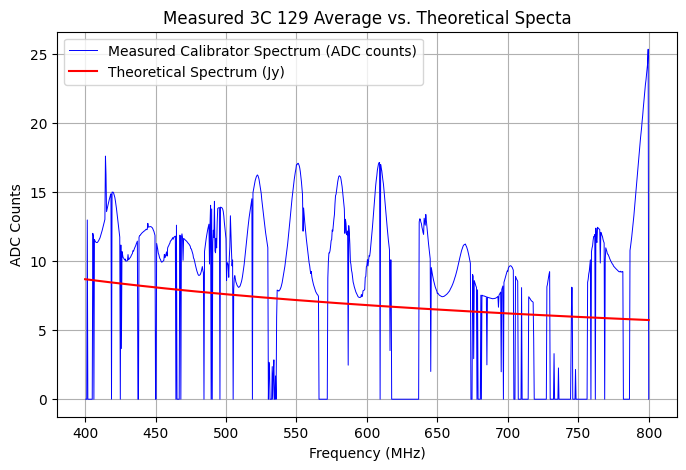

In [8]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_title("Measured 3C 129 Average vs. Theoretical Specta")
ax.plot(calibrator_source_Fil.header.chan_freqs, calibrator_source_Fil.chan_stats.mean, label="Measured Calibrator Spectrum (ADC counts)", color='blue', linewidth=0.7)
ax.plot(chime_freqs, flux_theory, label="Theoretical Spectrum (Jy)", color='red')
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("ADC Counts")
ax.legend()
ax.grid(True)

### Analysis of Spectrum

Comparing the two spectra above, there are a couple of notable differences. First and foremost, it is clear that while the theoretical spectrum is smoothly varying (as it should be since it is just a power law), the measured calibration source spectrum has many bumps in it. These bumps are also somewhat periodic and do not necessarily appear as truly random, though this could just be by chance since any features or bumps in the measured calibration data is clearly a sign that the data is straying from the power law model that can be used to model the emission from the source. Finally, although it is not necessarily an odd feature, we can make out noticable RFI features in the higher frequencies around 750 MHz caused by common cell networks and broadcast transmission frequencies.

## Part 3: Transfer Function

In order to be able to plot the measured spectra in the correct units (ie. converting ADC counts to Jy), we need to compute a transfer function that takes us from on set of units to the other. However, before we can compute the transfer function, we need to excise any RFI to avoid these effects propagating into the transfer function. We begin by removing and plotting the RFI in the in the cell below, with the transfer function calculation to follow.

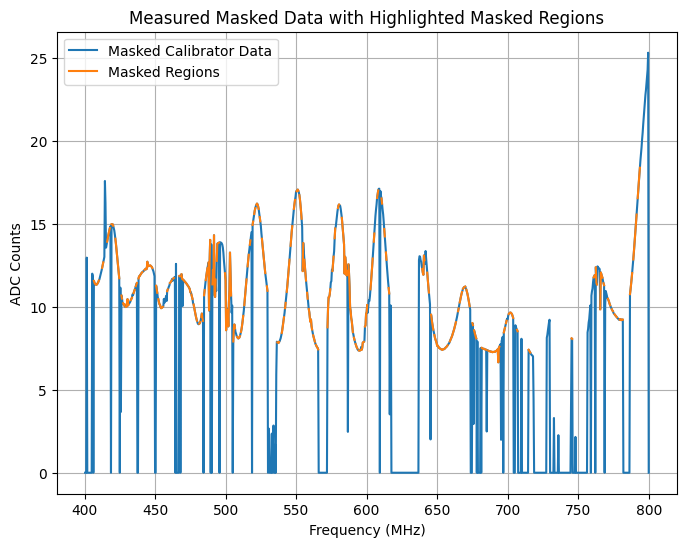

In [9]:
#---------------------------------------------------------------
#1. RFI Removal
#---------------------------------------------------------------
#This step can be performed by masking the RFI straightforwardly using sigpyproc:
_, chan_mask = calibrator_source_Fil.clean_rfi(method='mad', threshold=3)

#Since the above step creates a new masked Fil file, we can load it in and plot similar to above:
calibrator_source_Fil_masked = FilReader('calibrator_source_masked.fil')

#once again call the compute stats method anticipating plotting
calibrator_source_Fil_masked.compute_stats()

#Create a boolean array identifying where the masked channels are
freq_mask = calibrator_source_Fil_masked.chan_stats.mean == 0

fig, ax = plt.subplots(figsize = (8, 6))
ax.plot(calibrator_source_Fil_masked.header.chan_freqs,
        calibrator_source_Fil.chan_stats.mean, '-', label = 'Masked Calibrator Data')
ax.plot(calibrator_source_Fil_masked.header.chan_freqs,
        np.where(~freq_mask, calibrator_source_Fil_masked.chan_stats.mean, np.nan),  label = 'Masked Regions') #use bit-wise not operator, ~, to highlight what has NOT been masked
ax.set_title("Measured Masked Data with Highlighted Masked Regions")
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("ADC Counts")
ax.legend()
ax.grid(True)



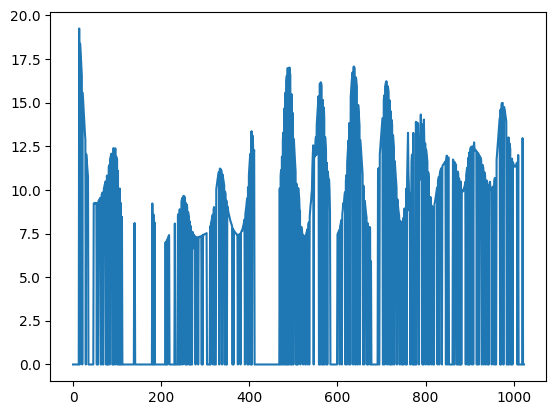

In [21]:
plt.plot(calibrator_source_Fil_masked.chan_stats.mean)

/tmp/ipykernel_360390/2374887245.py:7: RuntimeWarning: divide by zero encountered in divide
  transfer_function = flux_theory/calibrator_source_Fil_masked.chan_stats.mean


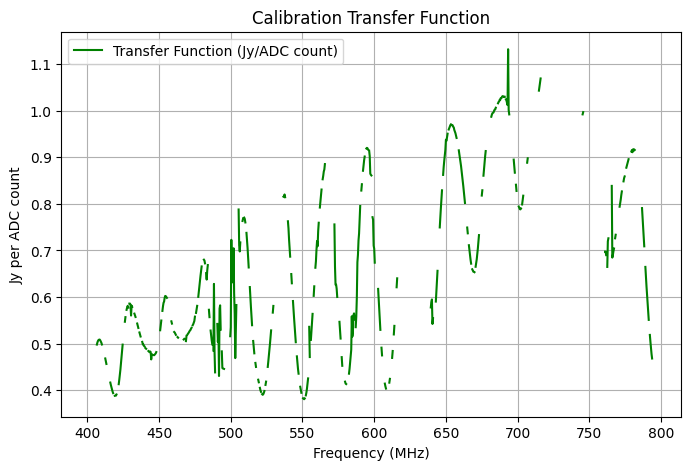

In [ ]:
#---------------------------------------------------------------
#2. Transfer Function
#---------------------------------------------------------------
#Transfer function is determined for each frequency channel by computing the following:
#(Jy per ADC count) = (theoretical flux in Jy) / (measured average ADC counts)
#This transfer function assumes that the average ADC counts are (linearly) proportional to flux.
transfer_function = flux_theory/calibrator_source_Fil_masked.chan_stats.mean

#Plotting the transfer function:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(calibrator_source_Fil_masked.header.chan_freqs, transfer_function, color='green', label='Transfer Function (Jy/ADC count)')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Jy per ADC count')
ax.set_title('Calibration Transfer Function')
ax.legend()
ax.grid(True)

### Applying the transfer function

With the RFI removal complete and the transfer function in hand, we can now apply the transfer function to calibrator source file to convert the units from ADC counts to Jy.

/tmp/ipykernel_360390/1202041599.py:13: RuntimeWarning: invalid value encountered in multiply
  calibrator_data = calibrator_source_Fil_masked_array*transfer_function[:, None]
/tmp/ipykernel_360390/1202041599.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


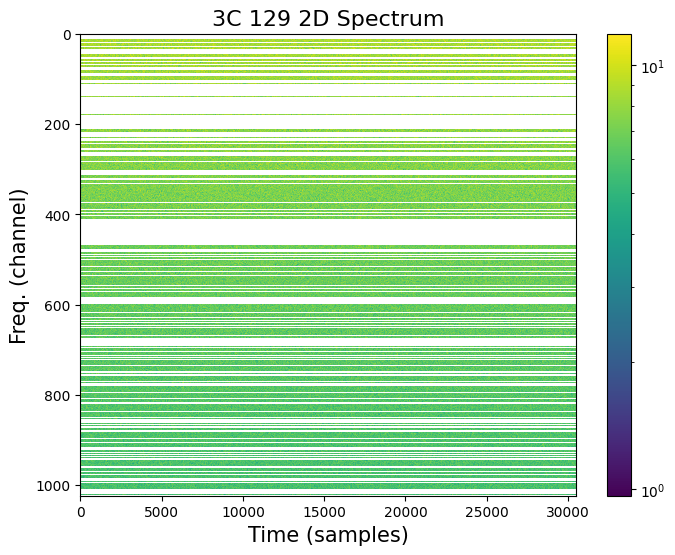

In [11]:
#Linear relationship so we can just multiply the measured calibrator data by the transfer function:

#read in the masked data and convert to array
calibrator_source_Fil_masked_data = calibrator_source_Fil_masked.read_block(0,
                                      calibrator_source_Fil_masked.header.nsamples,
                                      calibrator_source_Fil_masked.header.fch1,
                                      calibrator_source_Fil_masked.header.nchans
                                      )

calibrator_source_Fil_masked_array = calibrator_source_Fil_masked_data.data

#Apply the transfer function to the calibrator masked array data
calibrator_data = calibrator_source_Fil_masked_array*transfer_function[:, None]

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(calibrator_data, aspect='auto', interpolation='nearest', norm='log')
ax.set_title('3C 129 2D Spectrum', fontsize = 16)
ax.set_xlabel('Time (samples)', fontsize = 15)
ax.set_ylabel('Freq. (channel)', fontsize = 15)
fig.colorbar(im)
fig.show()

### Analysis of Flux-Calibrated 3C 129 Spectrum

The waterfall plot representing the 2D spectrum of the flux-calibrated calibrator source shows the similar RFI channels removed as can be seen when examining the average spectrum in the earlier sections. Additionally, the colorbar shows a range that spans roughly 1 to 10 Jy which also aligns with the expected range of flux densities shown in the theoretical spectrum. Finally, the plot overall does seem to show some level of 'grainy-ness', which could be due to noise introduced during the data collection process.

To further check things are working the way we expect, we can also plot the average spectrum after applying the transfer function. Since the transfer function was calculated by dividing the theoretical spectrum by the average spectrum of the calibrator source, we expect to get back (up to some RFI removed channels) the original theoretical spectrum. Indeed this can be seen in the plot produced by the code in the cell below.

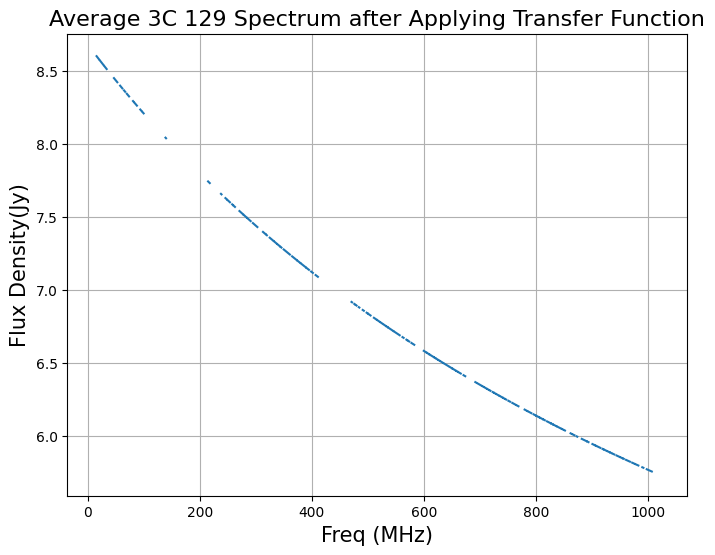

In [12]:
#Plotting the average calibrator data adjusted using the transfer function:
fig, ax = plt.subplots(figsize = (8, 6))
ax.plot(np.mean(calibrator_data, axis = 1)) #finding the mean over the time samples axis (ie. axis 1)
ax.set_title('Average 3C 129 Spectrum after Applying Transfer Function', fontsize = 16)
ax.set_xlabel('Freq (MHz)', fontsize = 15)
ax.set_ylabel('Flux Density(Jy)', fontsize = 15)
ax.grid(True)
plt.show()

## Part 4: Transfer Function Applied to Blank Sky Dataset



In [13]:
blank_sky_data = blank_sky_Fil.read_block(0,
                                      blank_sky_Fil.header.nsamples,
                                      blank_sky_Fil.header.fch1,
                                      blank_sky_Fil.header.nchans
                                      )

In [14]:
#Apply the transfer function to the blank sky data
calibrated_blank_sky_data = blank_sky_data.data*transfer_function[:, None]

#Also compute the average spectrum
avg_blank_sky_spectrum = np.mean(calibrated_blank_sky_data, axis = 1)

/tmp/ipykernel_360390/3875762427.py:2: RuntimeWarning: invalid value encountered in multiply
  calibrated_blank_sky_data = blank_sky_data.data*transfer_function[:, None]


In [15]:
#save the transfer function for later use
np.save('transfer_function.npy', transfer_function)

Now we can go ahead and use the calibrated blank sky data and the average spectrum array to make the desired plots.

As a quick step just before moving on, let's save the numpy array to disk for the average blank sky spectrum for future use in the next part of the project.

In [16]:
#make sure is a numpy array
print(type(avg_blank_sky_spectrum))

#using Numpy to save the array to disk
np.save('avg_blank_sky_spectrum.npy', avg_blank_sky_spectrum)

<class 'numpy.ndarray'>


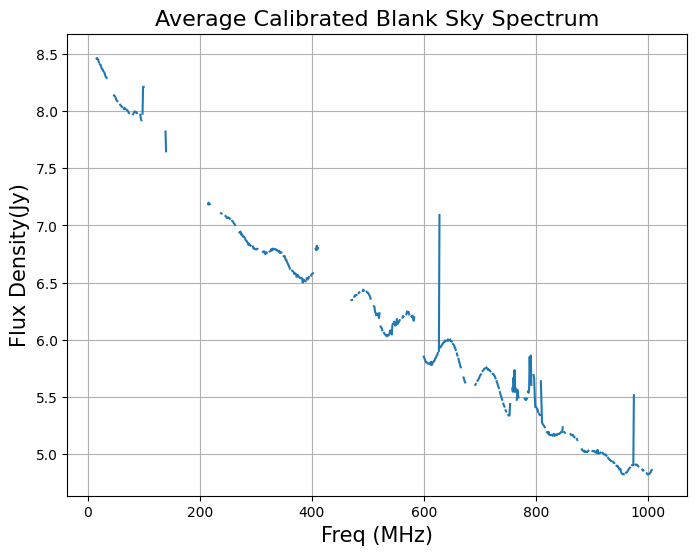

In [17]:
#Plotting average spectrum
fig, ax = plt.subplots(figsize = (8, 6))
ax.plot(avg_blank_sky_spectrum)
ax.set_title('Average Calibrated Blank Sky Spectrum', fontsize = 16)
ax.set_xlabel('Freq (MHz)', fontsize = 15)
ax.set_ylabel('Flux Density(Jy)', fontsize = 15)
ax.grid(True)
plt.show()

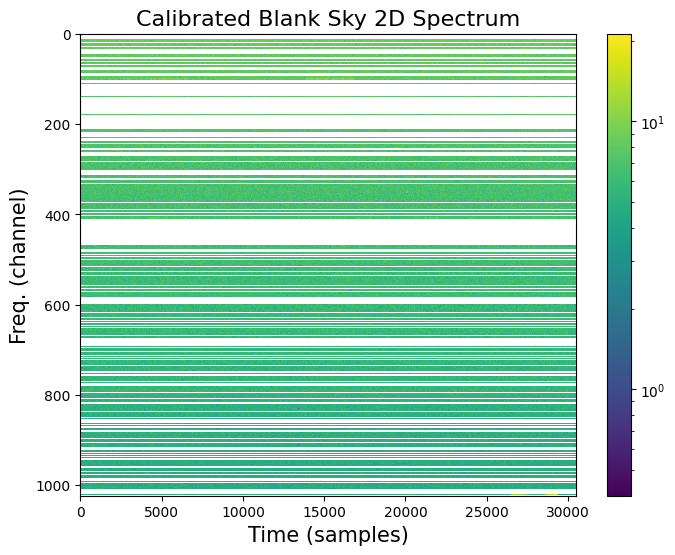

In [18]:
#Plotting the blank sky waterfall plot
fig, ax = plt.subplots(figsize = (8, 6))
im = plt.imshow(calibrated_blank_sky_data, aspect='auto', interpolation='nearest', norm='log')
fig.colorbar(im)
ax.set_title('Calibrated Blank Sky 2D Spectrum', fontsize = 16)
ax.set_xlabel('Time (samples)', fontsize = 15)
ax.set_ylabel('Freq. (channel)', fontsize = 15)
plt.show()

### Blank Sky Average Spectrum and Waterfall Plot Analysis

The most notable difference between the average spectrum for the blank sky and the calibrator source (after the transfer function has been applied) is the presence of bumps still visible in the blank sky spectrum. It makes sense that we can retrieve the 'ideal' spectrum after applying the transfer function to the calibrator data, since we used the calibrator data and the ideal spectrum to calculate the transfer function. However, it is clear that the transfer function simply acts to scale the data by some amount and is not able to smooth out the ripples present in the blank sky data. Additionally, the blank sky average spectrum appears to be almost linear, though this seems likely given that many astrophysical sources follow a power law distribution.

## Part 5: Noise Statistics

At this point, we would like to try and characterize the noise in the blank sky data set. Since the rms error is given by the radiometer equation, we expect that for a large number of samples, the distibution should approach a Gaussian distribution. We can begin by computing the mean and standard deviation per frequency channel, then use those to create a standard normal distribution.

/home/mike/anaconda3/envs/641_projects_py12/lib/python3.12/site-packages/numpy/_core/_methods.py:185: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/tmp/ipykernel_360390/3154316912.py:11: RuntimeWarning: invalid value encountered in subtract
  norm_calibrated_blank_sky = (calibrated_blank_sky_data - mean_per_channel[:, None])/std_per_channel[:, None]


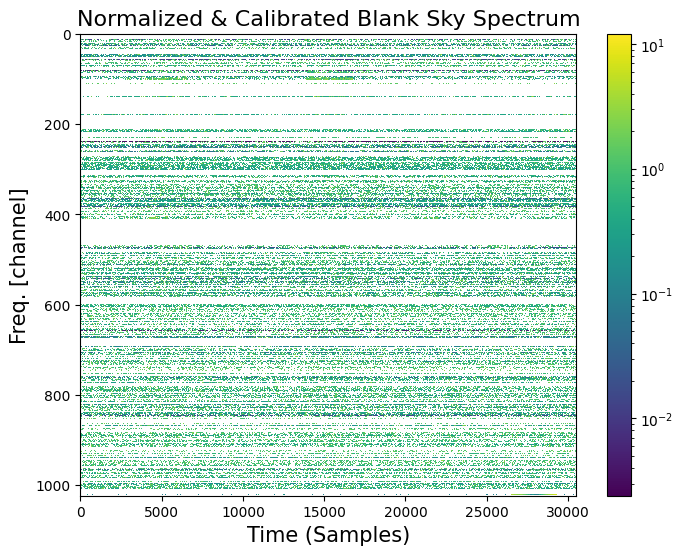

In [19]:
#mean per channel
mean_per_channel = np.mean(calibrated_blank_sky_data, axis=1)
# print(calibrated_blank_sky_data.shape)

#standard dev per channel
std_per_channel = np.std(calibrated_blank_sky_data, axis=1)
# print(std_per_channel[300:400])
# print(std_per_channel.shape)

#Compute the normalized calibrated blank sky data set
norm_calibrated_blank_sky = (calibrated_blank_sky_data - mean_per_channel[:, None])/std_per_channel[:, None]

#Create the waterfall plot
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(norm_calibrated_blank_sky, aspect='auto', interpolation='nearest', norm='log')
ax.set_title('Normalized & Calibrated Blank Sky Spectrum', fontsize=16)
ax.set_xlabel('Time (Samples)', fontsize=15)
ax.set_ylabel('Freq. [channel]', fontsize=15)
fig.colorbar(im)
plt.show()

### Characterizing Noise

The final step is to get a sense for what kind of noise dominates the frequency channels. As eluded to above, we expect this to be Gaussian, but we can plot a histogram for several different channels to see if this really is the case.

The dimensions of the calibrated blank sky data set are: (1024, 30518)


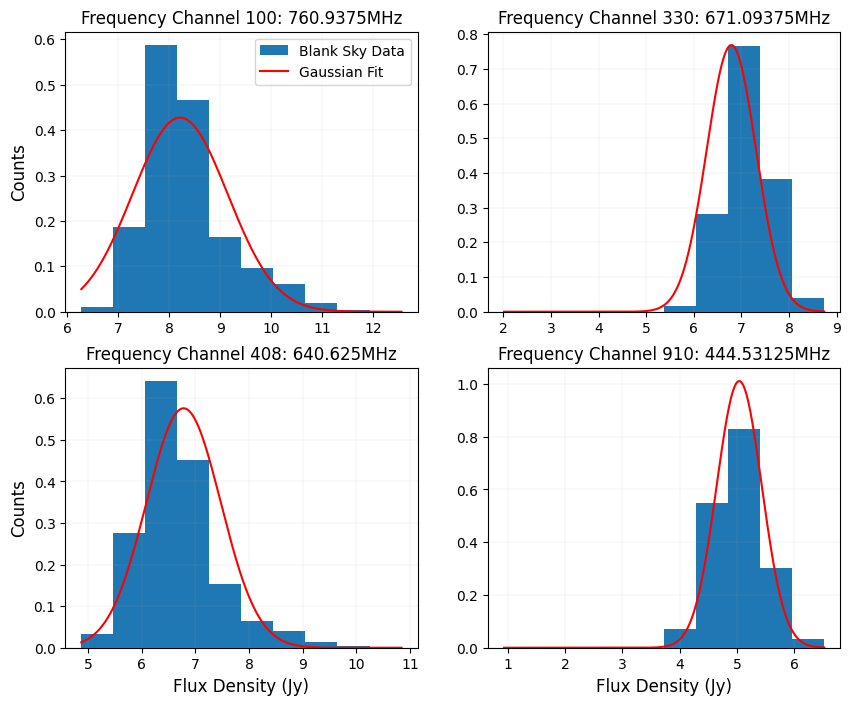

In [20]:
#The dimensions of the calibrated blank sky data set are (1024, 30518)
print(f"The dimensions of the calibrated blank sky data set are: {calibrated_blank_sky_data.shape}")

#We can manually select several frequency channels (rows in the calibrated blank sky data) to use:
#Selecting a representative set of frequency channels to plot. Noting, however, that many channels contain NAN or inf values and so these channels have been hand-picked
freq_idxs = [100, 330, 408, 910]

#define the theoretical Gaussian curve to plot over the histograms
def Guassian_dist(x, mean, std):
    norm = 1/(std*np.sqrt(2*np.pi))
    return norm*np.exp(-(1/2) * ((x - mean)/std)**2)

# Use the data range for the selected frequency channel and create a set of xvals to plot over
xvals1 = np.linspace(calibrated_blank_sky_data[freq_idxs[0]].min(),
                    calibrated_blank_sky_data[freq_idxs[0]].max(), 1000)
xvals2 = np.linspace(calibrated_blank_sky_data[freq_idxs[1]].min(),
                    calibrated_blank_sky_data[freq_idxs[1]].max(), 1000)
xvals3 = np.linspace(calibrated_blank_sky_data[freq_idxs[2]].min(),
                    calibrated_blank_sky_data[freq_idxs[2]].max(), 1000)
xvals4 = np.linspace(calibrated_blank_sky_data[freq_idxs[3]].min(),
                    calibrated_blank_sky_data[freq_idxs[3]].max(), 1000)


#plot the 4 histograms (one for each frequency channel selected above
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

ax[0,0].hist(calibrated_blank_sky_data[freq_idxs[0]], density=True, label='Blank Sky Data')
ax[0,1].hist(calibrated_blank_sky_data[freq_idxs[1]], density=True)
ax[1,0].hist(calibrated_blank_sky_data[freq_idxs[2]], density=True)
ax[1,1].hist(calibrated_blank_sky_data[freq_idxs[3]], density=True)

ax[0,0].plot(xvals1, Guassian_dist(xvals1, mean_per_channel[freq_idxs[0]], std_per_channel[freq_idxs[0]]), color='red', label = 'Gaussian Fit')
ax[0,1].plot(xvals2, Guassian_dist(xvals2, mean_per_channel[freq_idxs[1]], std_per_channel[freq_idxs[1]]), color='red')
ax[1,0].plot(xvals3, Guassian_dist(xvals3, mean_per_channel[freq_idxs[2]], std_per_channel[freq_idxs[2]]), color='red')
ax[1,1].plot(xvals4, Guassian_dist(xvals4, mean_per_channel[freq_idxs[3]], std_per_channel[freq_idxs[3]]), color='red')

ax[0,0].set_title(f'Frequency Channel {freq_idxs[0]}: {blank_sky_Fil.header.chan_freqs[freq_idxs[0]]}MHz')
ax[0,1].set_title(f'Frequency Channel {freq_idxs[1]}: {blank_sky_Fil.header.chan_freqs[freq_idxs[1]]}MHz')
ax[1,0].set_title(f'Frequency Channel {freq_idxs[2]}: {blank_sky_Fil.header.chan_freqs[freq_idxs[2]]}MHz')
ax[1,1].set_title(f'Frequency Channel {freq_idxs[3]}: {blank_sky_Fil.header.chan_freqs[freq_idxs[3]]}MHz')

ax[0,0].set_ylabel('Counts', fontsize = 12)
ax[1,0].set_ylabel('Counts', fontsize = 12)
ax[1,0].set_xlabel('Flux Density (Jy)', fontsize = 12)
ax[1,1].set_xlabel('Flux Density (Jy)', fontsize = 12)

ax[0,0].grid(True, linewidth=0.1)
ax[0,1].grid(True, linewidth=0.1)
ax[1,0].grid(True, linewidth=0.1)
ax[1,1].grid(True, linewidth=0.1)

ax[0,0].legend()
plt.show()

Examining the plots above, we can see that although the bins are quite large, there is a resemblence between the shape of the distribution of the measured data and the theoretical Gaussian curve that is plotted using each respective mean and standard deviation. From this set of subplots, we can say (at least qualitatively) that the noise charactarizing the blank sky data set is indeed Gaussian distributed.